In [74]:
import scipy.stats as stats 
import pymc as pm
import numpy as np
import arviz as az
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [75]:
np.random.seed(42)

In [76]:
#Генерируем данные
p_a=0.1
p_b=0.12
n_users=1000

convers_a=np.random.binomial(1, p_a, n_users)
convers_b=np.random.binomial(1, p_b, n_users)
uspeh_a=convers_a.sum()
uspeh_b=convers_b.sum()
total_a=len(convers_a)
total_b=len(convers_b)
print(uspeh_a, uspeh_b, total_a, total_b)

100 112 1000 1000


In [77]:
print("Эксперимент")
print(f"ver_A: {uspeh_a} iz {total_a} ({uspeh_a/total_a:.4f}%)")
print(f"ver_B {uspeh_b} iz {total_b} ({uspeh_b/total_b:.4f}%)")
print(f"Istinnoe cr: A - {p_a:.4f}, B - {p_b:.4f}")

Эксперимент
ver_A: 100 iz 1000 (0.1000%)
ver_B 112 iz 1000 (0.1120%)
Istinnoe cr: A - 0.1000, B - 0.1200


In [78]:
### Строим модель
with pm.Model() as ab_test_model:
    p_A=pm.Beta('p_A', alpha=1, beta=1)
    p_B=pm.Beta('p_B', alpha=1, beta=1)
    delta=pm.Deterministic('delta', p_B-p_A)
    lift=pm.Deterministic('lift', p_B/p_A-1)
    obs_A=pm.Binomial('obs_A', n=total_a,p=p_A, observed=uspeh_a)
    obs_B=pm.Binomial('obs_B', n=total_b, p=p_B, observed=uspeh_b)

    trace=pm.sample(2000, tune=1000, return_inferencedata=False, progressbar=False)



In [79]:
print("Результаты\n")
print(f"CR grA: sred {trace['p_A'].mean():.3f}, 95% interval: {np.percentile(trace['p_A'],2.5):.3f} - {np.percentile(trace['p_A'],97.5):.3f}")
print(f"CR grB: sred {trace['p_B'].mean():.3f}, 95% interval: {np.percentile(trace['p_B'],2.5):.3f} - {np.percentile(trace['p_B'],97.5):.3f}")
prob_B_A=(trace['delta']>0).mean()
print (f"С ввероятностью {prob_B_A:.4f} В лучше A ")

print(f"Ожидаемая абс. разница {trace['delta'].mean():.3f}")
print(f"Ожидаемая относ. разница {trace['lift'].mean()*100:.2f}%")

print('\nРекомендация')
if prob_B_A>=0.95:
    print("Рекомендуется верс В")
elif prob_B_A>=0.8:
    print("Скорее всего В лучше А, можно еще подержать тест")
elif prob_B_A>=0.6:
    print("Возможно В лучше А, тестируем дальше")
else:
    print("Версия В не лучше А")



Результаты

CR grA: sred 0.101, 95% interval: 0.083 - 0.120
CR grB: sred 0.113, 95% interval: 0.094 - 0.133
С ввероятностью 0.8085 В лучше A 
Ожидаемая абс. разница 0.012
Ожидаемая относ. разница 13.28%

Рекомендация
Скорее всего В лучше А, можно еще подержать тест


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

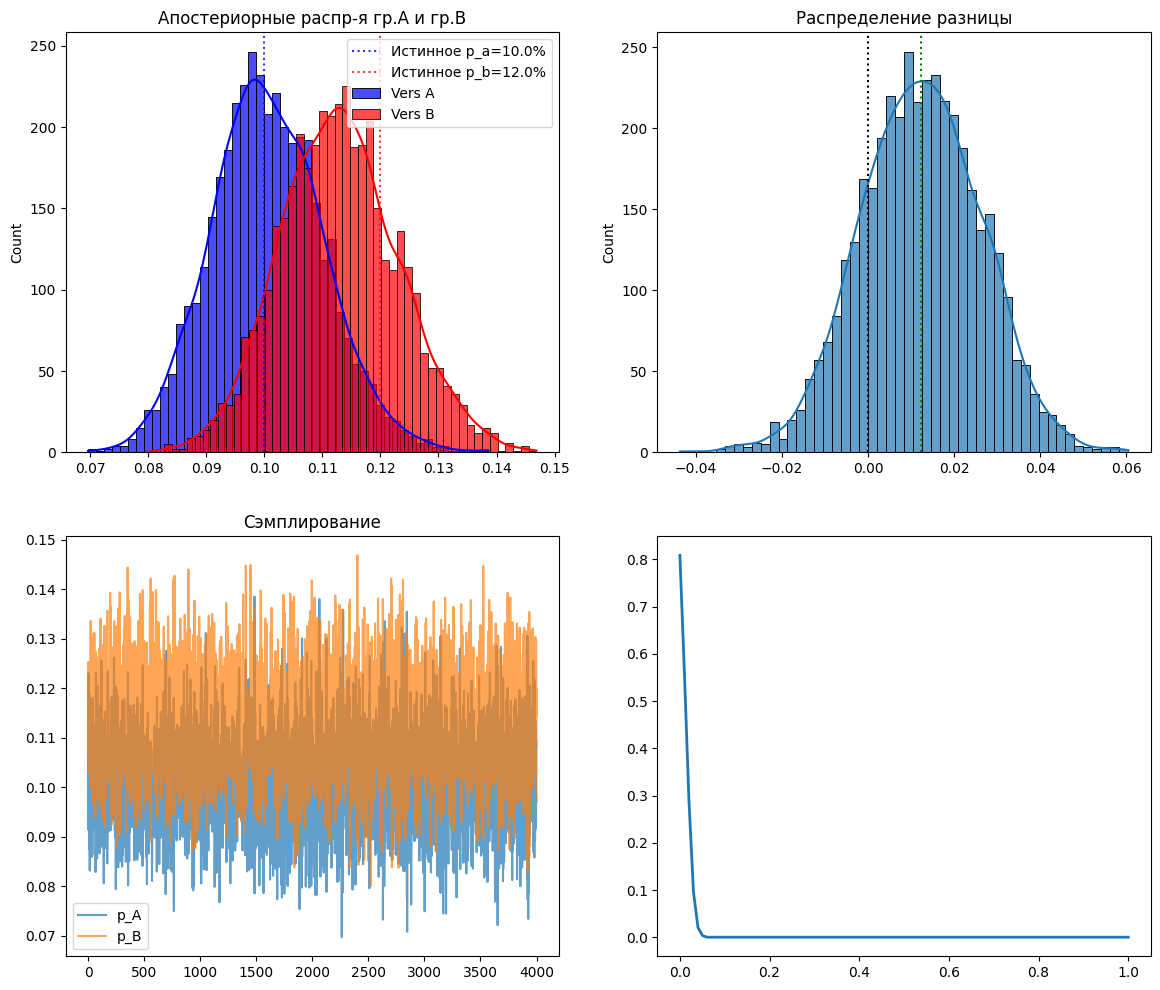

In [ ]:
### Вмзуализация
fig, axes=plt.subplots(2,2, figsize=(14,12))
sns.histplot(trace['p_A'], bins=50, alpha=0.7, label='Vers A', color='blue',ax=axes[0,0], kde=True)
sns.histplot(trace['p_B'], bins=50, alpha=0.7, label='Vers B', color='red', ax=axes[0,0],kde=True)
axes[0,0].axvline(p_a, color='blue', linestyle=':', alpha=0.8, label=f'Истинное p_a={p_a:.1%}')
axes[0,0].axvline(p_b, color='red', linestyle=':', alpha=0.8, label=f'Истинное p_b={p_b:.1%}')
axes[0,0].set_title("Апостериорные распр-я гр.А и гр.B")
axes[0,0].legend()

sns.histplot(trace['delta'],bins=50,alpha=0.7,ax=axes[0,1],kde='True')
axes[0,1].axvline(0, color='black',linestyle=':')
axes[0,1].axvline(trace['delta'].mean(), color='green',linestyle=':')
axes[0,1].set_title("Распределение разницы")

sns.lineplot(trace['p_A'], alpha=0.7, label='p_A', ax=axes[1,0])
sns.lineplot(trace['p_B'], alpha=0.7, label='p_B', ax=axes[1,0])
axes[1,0].set_title('Сэмплирование')

x=np.linspace(0,1,100)
# print(x)
y=[((trace['delta']>porog).mean()) for porog in x]
# print(y)
axes[1,1].plot(x, y,linewidth=2)
plt.show();


In [81]:
### Уверенность при различных выборках данных
sample_sizes=[50,100,250,500,750,1000]
proba=[]
for n in sample_sizes:
    conv_a=convers_a[:n].sum()
    conv_b=convers_b[:n].sum()

    with pm.Model() as part_model:
        p_A_part=pm.Beta('p_A', alpha=1, beta=1)
        p_B_part=pm.Beta('p_B', alpha=1, beta=1)
        delta_part=pm.Deterministic('delta',p_B_part-p_A_part)
        obs_A_part=pm.Binomial('obs_A', n=n,p=p_A_part, observed=conv_a)
        obs_B_part=pm.Binomial('obs_B', n=n, p=p_B_part, observed=conv_b)

        trace_part=pm.sample(1000, tune=500,progressbar=False,return_inferencedata=False)
        prb=(trace_part['delta']>0).mean()
        proba.append(prb)
        print(f"{n} наблюдений - B лучше А {prb:.1%}")

50 наблюдений - B лучше А 80.0%
100 наблюдений - B лучше А 93.5%
250 наблюдений - B лучше А 90.0%
500 наблюдений - B лучше А 65.0%
750 наблюдений - B лучше А 81.0%
1000 наблюдений - B лучше А 80.8%


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


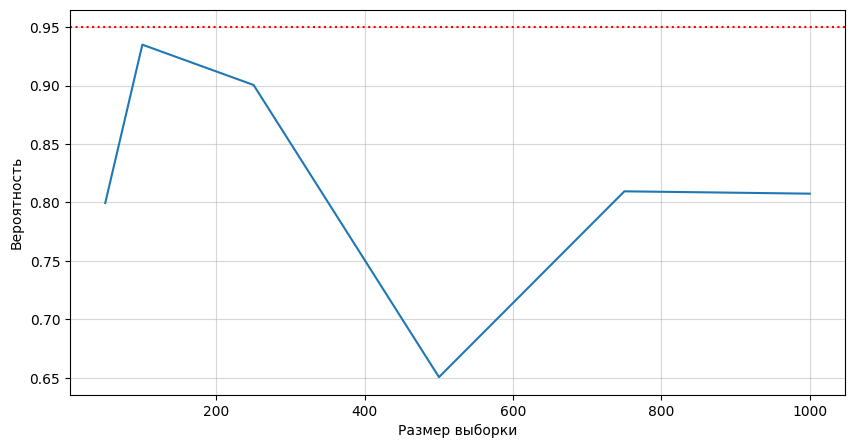

In [82]:
pd.option_context('mode.use_inf_as_na', True)
df_part=pd.DataFrame({'Размер выборки':sample_sizes, 'Вероятность':proba})
plt.figure(figsize=(10,5))
# plt.plot(sample_sizes,proba)
sns.lineplot(data=df_part, x='Размер выборки', y='Вероятность')
plt.axhline(0.95,color='red',label='95% порог', linestyle=':')
plt.grid(True, alpha=0.5)
plt.show();
